In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt   #jupyter要matplotlib.pyplot
from pytorch_transformers import BertConfig, BertTokenizer, BertModel, BertForMaskedLM
device = 'cuda' if torch.cuda.is_available() else 'cpu' 
device

'cuda'

In [21]:
tokenizer = BertTokenizer.from_pretrained('./bert-pretrained-chinese') #必须要./表示当前文件夹的某个文件

In [22]:
text = '[CLS]单武松打老虎[SEP] 你在哪[SEP]'
tokens = tokenizer.tokenize(text)
indexed_tokens = tokenizer.convert_tokens_to_ids(tokens)
segments_ids = [0,0,0,0,0,0,0,0,1,1,1,1]
tokens_tensor = torch.tensor([indexed_tokens])
segments_tensors = torch.tensor([segments_ids])
print(indexed_tokens)

[101, 1296, 3636, 3351, 2802, 5439, 5988, 102, 872, 1762, 1525, 102]


In [23]:
tokens_tensor.shape

torch.Size([1, 12])

In [24]:
model = BertModel.from_pretrained('./bert-pretrained-chinese')
model #创建bert模型并加再预训练参数

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(21128, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          

In [25]:
model.to(device)
tokens_tensor = tokens_tensor.to(device)
segments_tensors = segments_tensors.to(device) #放入gpu中

In [26]:
model.eval() #eval()将我们的模型置于评估模式，而不是训练模式。在这种情况下，评估模式关闭了训练中使用的dropout正则化。
with torch.no_grad():
    encoded_layers, pooled_output = model(tokens_tensor, segments_tensors)
encoded_layers.shape

torch.Size([1, 12, 768])

bert模型输入，tokens_tensor：经过字典序后的one-hot编码，segments_tensors:句子编码，输出encoded_layers：encoded_layer：长度为num_hidden_layers的(batch_size， sequence_length，hidden_size)的Tensor.列表
即输入的句子的每个字被转化为768维度的embedding

encoded_layer：长度为num_hidden_layers的(batch_size， sequence_length，hidden_size)的Tensor.列表
pooled_output: (batch_size, hidden_size), 最后一层encoder的第一个词[CLS]经过Linear层和激活函数Tanh()后的Tensor. 其代表了句子信息

In [27]:
import numpy as np
import pandas as pd
from pandas import DataFrame
train = pd.read_csv('./dataload/train.csv')
test = pd.read_csv('./dataload/test.csv')
print(train.shape)
print(test.shape)


(6022, 3)
(1506, 2)


In [28]:
text1 = train['text'][1]
tokens1 = tokenizer.tokenize(text1)
indexed_tokens1 = tokenizer.convert_tokens_to_ids(tokens1)
segments_ids1 = [0,0,0,0,0,0,0,0,1,1,1,1]
tokens_tensor1 = torch.tensor([indexed_tokens1])
segments_tensors1 = torch.tensor([segments_ids1])
print(indexed_tokens1)
print(tokens1)

[1296, 3403, 2769, 3300, 749, 8024, 3297, 6818, 8958, 1352, 3403, 6819, 4385, 3833, 1220, 1962]
['单', '标', '我', '有', '了', '，', '最', '近', 'visa', '双', '标', '返', '现', '活', '动', '好']


In [10]:
'''利用bert进行对train.csv的每句话分词，并且得到embedding'''
#获取文本经过bert处理的embedding vector
encoded_layers = []
tokens = []
for l in range(train.shape[0]):  #train.shape[0]表示有多少行数据
    token = tokenizer.tokenize(train['text'][l]) #词性标注任务我没有添加[CLS]和[SEP]
    tokens.append(token)

    indexed_token = tokenizer.convert_tokens_to_ids(token)
    indexed_token_tensor = torch.tensor([indexed_token]).to(device)

    segments_id = [1] * len(token)
    segments_id_tensor = torch.tensor([segments_id]).to(device)

    model.eval() #eval()将我们的模型置于评估模式，而不是训练模式。在这种情况下，评估模式关闭了训练中使用的dropout正则化。
    with torch.no_grad():
        word_embedding, pooled_output = model(indexed_token_tensor, segments_id_tensor)

    encoded_layers.append(word_embedding)



由于bert的tokenizer分词出来会把'visa'单独当成一个token，因此如果要把'visa'分成'v','i','s','a'就要先用one for one将每个字母和字分开，再带入bert中获得embedding

In [34]:
'''利用one for one 对train.csv的每句话进行分词，再带入bert得到embedding'''
encoded_layers = []
tokens = []
for l in range(train.shape[0]):  #train.shape[0]表示有多少行数据
    token = [one for one in train['text'][l]]
    tokens.append(token)

    indexed_token = tokenizer.convert_tokens_to_ids(token)
    indexed_token_tensor = torch.tensor([indexed_token]).to(device)

    segments_id = [1] * len(token)
    segments_id_tensor = torch.tensor([segments_id]).to(device)

    model.eval() #eval()将我们的模型置于评估模式，而不是训练模式。在这种情况下，评估模式关闭了训练中使用的dropout正则化。
    with torch.no_grad():
        word_embedding, pooled_output = model(indexed_token_tensor, segments_id_tensor)

    encoded_layers.append(word_embedding)

In [39]:
encoded_layers[0].shape


torch.Size([1, 84, 768])

In [41]:
'''获取bert的embedding dim'''
#batch_size, sequence_len, embedding_size
embedding_dim = encoded_layers[0].shape[2]
#bert的embedding dim

In [51]:
'''得到所有的命名实体的字典，然后根据字典得到train.csv每句话的命名实体字典值'''
def tag_to_tensor(tags, tag_to_ix):
    tag_idx = [tag_to_ix[w] for w in tags]
    return torch.tensor(tag_idx)

tag_to_ix = {"B-BANK": 0, "I-BANK": 1, "B-PRODUCT": 2, "I-PRODUCT": 3, "O": 4, "B-COMMENTS_N": 5, "I-COMMENTS_N": 6, "B-COMMENTS_ADJ": 7, "I-COMMENTS_ADJ": 8}  # Assign each tag with a unique index

tags = [] #tags是一个list，里面存放每个训练数据的文本对应的命名实体转化为字典tensor后的形式
for l in range(train.shape[0]):
    tag = train['BIO_anno'][l].split()  #将每一个BIO命名实体分离
    tag_tensors = tag_to_tensor(tag, tag_to_ix)
    tags.append(tag_tensors.to(device))

print(tags[0].shape)

torch.Size([84])


如果list中的元素为tensor，就无法用上述语句转换，会报错
ValueError: only one element tensors can be converted to Python scalars
遇到这种情况，一定要使用numpy形式存储于list中，然后再进行转换。

In [43]:
#pytorch LSTM模型架构
class LSTMTagger(nn.Module):

    def __init__(self, embedding_dim, hidden_dim, vocab_size, tagset_size):
        #LSTM的输入为连两个输入：input, (embedding_dim, hidden_dim),但是这里要用word2vec来embedding，所以要有后两个vocab_size等
        #输出：output, (hn,cn)，cn为
        super(LSTMTagger, self).__init__()
        self.hidden_dim = hidden_dim

        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)

        # The LSTM takes word embeddings as inputs, and outputs hidden states
        # with dimensionality hidden_dim.
        self.lstm = nn.LSTM(embedding_dim, hidden_dim)

        # The linear layer that maps from hidden state space to tag space
        self.hidden2tag = nn.Linear(hidden_dim, tagset_size)

    def forward(self, sentence):
        #forward里的参数决定了model的输入
        embeds = self.word_embeddings(sentence)
        lstm_out, _ = self.lstm(embeds.view(len(sentence), 1, -1))
        #LSTM的输出有两个，第一个是LSTM输出的embedding，第二个应该是lstm里的cell参数
        tag_space = self.hidden2tag(lstm_out.view(len(sentence), -1))
        #在lstm后加入了linear layer的输出，用于后面的softmax选取命名实体
        tag_scores = F.log_softmax(tag_space, dim=1)
        return tag_scores

In [44]:
#本文利用bert先获得训练数据embedding，再加LSTM的模型
'''
embedding_dim: bert输出的每个字的embedding vector长度
hidden_dim: LSTM的每层隐藏元个数，即经过LSTM转化后的embedding dim
tagset_size:命名实体BIO的总个数，用于分类
num_layers:LSTM层数
'''
class BertLSTM(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, tagset_size, num_layers):  #embedding_dim:bert处理后的字的ebedding size，hidden_dim：LSTM中对字的embedding size，tagset_size:BIO命名实体数量,num_layers:LSTM的层数

        super(BertLSTM,self).__init__()

        self.hidden_dim = hidden_dim #self
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers, batch_first=False, dropout=0.5, bias=True, bidirectional=True)
        #LSTM设置,前两个时必须有的，后面依次时LSTM层数，bias时y=wx+b的b，bidirectional双向LSTM
        self.hidden2tag = nn.Linear(hidden_dim, tagset_size)
        #线性层,要用softmax选择命名实体

    def forward(self, embedding_bert):  #forward表示模型在train中要输入的参数，这里只用输入文本经过bert的embedding表示
        hidden_dim = self.hidden_dim

        lstm_out, _ = self.lstm(embedding_bert.permute(1,0,2))
       #打乱embedding_bert顺序使其符合lstm的输入形式
        out = lstm_out[:,:, [i for i in range(hidden_dim)]]
        #取双向lstm输入的前一半部分,不能lstm.out.shape[2]/2，会改变为float类型
        tag_space = self.hidden2tag(out.view(embedding_bert.shape[1], -1))

        tag_scores = F.log_softmax(tag_space, dim=1)

        return tag_scores

        

In [45]:
a = np.random.randn(3,1,4)
b = torch.tensor(a)
c = b[:, :, [i for i in range(2)]]
c.shape
print(b)
print(c)

tensor([[[-0.5372, -0.6486,  0.8605, -0.0524]],

        [[ 0.3100,  0.6123, -0.2303, -0.5068]],

        [[ 0.3607,  0.1656, -0.0919, -1.0255]]], dtype=torch.float64)
tensor([[[-0.5372, -0.6486]],

        [[ 0.3100,  0.6123]],

        [[ 0.3607,  0.1656]]], dtype=torch.float64)


模拟双向lstm取前一半的值作为输出

LSTM 的输入是三维，其顺序是 (seq_len, batch, input_size),因此在传进去的时候要注意是否匹配
seq_len:句子有几个token
input_size:x的特征维度
x.permute变换tensor维度

lstm输出数据：
output： 维度和输入数据类似，只不过最后的feature部分会有点不同，即 (seq_len, batch, num_directions * hidden_size)

如：
x = torch.randn(2, 3, 5)
print(x.size())
print(x.permute(2, 0, 1).size())

>>>torch.Size([2, 3, 5])
>>>torch.Size([5, 2, 3])

In [46]:
'''定义LSTM模型'''
model_LSTM = BertLSTM(embedding_dim, 256, len(tag_to_ix), 3).to(device)
loss_function = nn.NLLLoss() #和log softmax搭配使用
optimizer = optim.SGD(model_LSTM.parameters(), lr=0.01)


In [47]:
tags[0].shape
encoded_layers[0].shape
tags[1].shape
encoded_layers[1].shape

torch.Size([1, 19, 768])

In [101]:
'''定义训练函数'''
def train_LSTM(model, loss_func, optimizer, tags, encoded_layers, epochs):
    losses = []
    iter = []
    for epoch in range(epochs):
        loss_sum=0
        for l in range(len(encoded_layers)):
            if encoded_layers[l].shape[1] != len(tags[l]):
                continue
            #如果命名实体数量和token数量不同，跳过本句
            model.zero_grad() #新batch训练时将梯度归0，防止梯度累积
            tag_scores = model(encoded_layers[l])
            loss = loss_func(tag_scores, tags[l])
            loss.backward()
            optimizer.step()

            loss_sum+=loss.item()
            
        losses.append(loss_sum)
        iter.append(epoch)
        print("the loss of"+ str(epoch) + "is" + str(loss_sum))
    
    plt.title("loss of epoch per————"+str(loss_func)+ ","+ str(epochs)+ "epochs")
    plt.xlabel("loss per 1")
    plt.ylabel("LOSS")
    plt.plot(iter, losses)
    plt.show()


    

In [97]:
encoded_layers[0].shape[1] != tags[0].shape
print(encoded_layers[0].shape[1])
print(len(tags[0]))
print(tags[0].shape)

84
84
torch.Size([84])


In [65]:
encoded_layers[0].shape

torch.Size([1, 84, 768])

the loss of0is2884.914151276462
the loss of1is2534.033711817581
the loss of2is2248.3375493022613
the loss of3is2003.7740695099346
the loss of4is1827.4039800853934
the loss of5is1655.067159080645
the loss of6is1531.0094499249244
the loss of7is1419.7208306726534
the loss of8is1308.4929540661396
the loss of9is1220.6540562426671


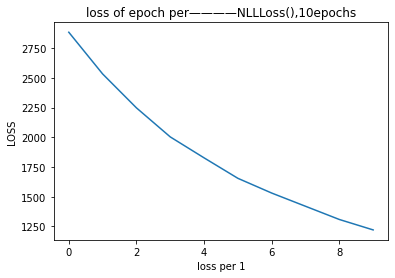

In [103]:
train_LSTM(model_LSTM, loss_function, optimizer, tags, encoded_layers, 10)

In [143]:
'''把所有的token的bert embedding放入LSTM模型中进行一次正向传播，此时模型和数据都还在device对应的设备上'''
model_LSTM.eval()
tag_scores_all = []
with torch.no_grad():
    for l in range(train.shape[0]):
        temp = model_LSTM(encoded_layers[l])#前向传播一次获得每句话每个字对应的命名实体BIO的softmax分数tensor
        tag_scores_all.append(temp)

In [146]:
tag_scores_all[0][0]

tensor([-0.5630, -3.1421, -5.0234, -8.0535, -0.9799, -6.5956, -7.7917, -5.9795,
        -7.1931], device='cuda:0')

In [151]:
'''把train中所有句子的BIO命名实体放入BIO_all中'''
BIO_all=[]
for i in range(len(tag_scores_all)):#对于每一句
    max_indexs = []
    BIO = []
    for j in range(tag_scores_all[i].shape[0]):#对于每一句的每个token
        tag_scores = tag_scores_all[i]
        tag_score_list = list(tag_scores[j])

        max_val = max(tag_scores[j])
        max_index = tag_score_list.index(max_val)

        max_indexs.append(max_index)  #一句话的对应的最大索引
    for index in max_indexs:
        BIO.append(list(tag_to_ix.keys())[index])#把tag_to_ix的键（key）转化为list，然后找到index对应位置的key
    
    BIO_all.append(BIO)

